<a href="https://colab.research.google.com/github/sebauribeo/deteccionFraudes/blob/Staging/evaluacion_3_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *1.- Importación de Librerías y Carga de Datos*

En esta sección, importamos todas las librerías necesarias para el análisis de datos, preprocesamiento, modelado y evaluación. También cargamos el conjunto de datos que utilizaremos para entrenar y probar nuestro modelo.

In [1]:
!pip install catboost

# Importar librerías esenciales para manejo de datos y visualización
import pandas as pd  # Manejo de datos en formato tabular
import numpy as np  # Operaciones numéricas
import matplotlib.pyplot as plt  # Generación de gráficos
import seaborn as sns  # Gráficos avanzados basados en Matplotlib

# Librerías para preprocesamiento y modelos clásicos
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Codificación y escalado de datos
from sklearn.model_selection import train_test_split  # División de datos en entrenamiento y prueba
from sklearn.metrics import classification_report, confusion_matrix  # Métricas para evaluar modelos

# Librería para manejo del desbalanceo de clases
from imblearn.over_sampling import SMOTE  # Generación de datos sintéticos para balancear clases

# Librerías de PyTorch para redes neuronales
import torch  # Biblioteca principal de PyTorch
import torch.nn as nn  # Definición de redes neuronales
from torch.utils.data import TensorDataset, DataLoader  # Manejo eficiente de datasets y minibatches

# Importación de modelos clásicos
from sklearn.linear_model import LogisticRegression  # Regresión logística
from sklearn.tree import DecisionTreeClassifier  # Árbol de decisión
from catboost import CatBoostClassifier  # Modelo avanzado de CatBoost

# Cargar el dataset
data = pd.read_csv('/content/financial_dataset.csv')

# *2.- Preprocesamiento de Datos*
En esta sección, realizamos un análisis inicial de los datos, manejamos valores faltantes y codificamos variables categóricas. Creamos características adicionales que pueden ser útiles para el modelo y seleccionamos las características relevantes. Finalmente, estandarizamos los datos para prepararlos para el entrenamiento.
## a.- Exploración Inicial

In [2]:
# Visualizar las primeras filas del dataset
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## b.- Manejo de Valores Faltantes

In [3]:
# Verificar valores faltantes en cada columna
print("Valores faltantes por columna:")
print(data.isnull().sum())

# Eliminar filas con valores faltantes en 'isFraud'
data = data.dropna(subset=['isFraud'])

# Opcional: También podemos eliminar filas con valores faltantes en las características
data = data.dropna()


Valores faltantes por columna:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## c.- Codificación de Variables Categóricas

In [4]:
# Crear una instancia de LabelEncoder para codificar variables categóricas
label_encoder = LabelEncoder()

# Codificar la columna 'type' y agregarla como una nueva columna 'type_encoded'
data['type_encoded'] = label_encoder.fit_transform(data['type'])


## d.- Creación de Características Adicionales

In [5]:
# Crear características adicionales basadas en los balances
data['errorBalanceOrig'] = data['newbalanceOrig'] + data['amount'] - data['oldbalanceOrg']
data['errorBalanceDest'] = data['oldbalanceDest'] + data['amount'] - data['newbalanceDest']

## e.- Selección de Características Relevantes

In [6]:
# Definir las características que se utilizarán para entrenar el modelo
features = ['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']

# Crear la matriz de características 'X' y el vector objetivo 'y'
X = data[features]           # Características de entrada
y = data['isFraud']          # Variable objetivo (0: no fraude, 1: fraude)

## f.- Estandarización de Datos

In [7]:
# Crear una instancia de StandardScaler para estandarizar las características
scaler = StandardScaler()

# Ajustar el escalador a los datos y transformar las características
X_scaled = scaler.fit_transform(X)

# *3. Análisis Exploratorio de Datos (EDA)*
Exploramos la distribución de las clases y visualizamos la variable objetivo para detectar desbalances.
## a.-Distribución de Clases


Distribución de clases:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


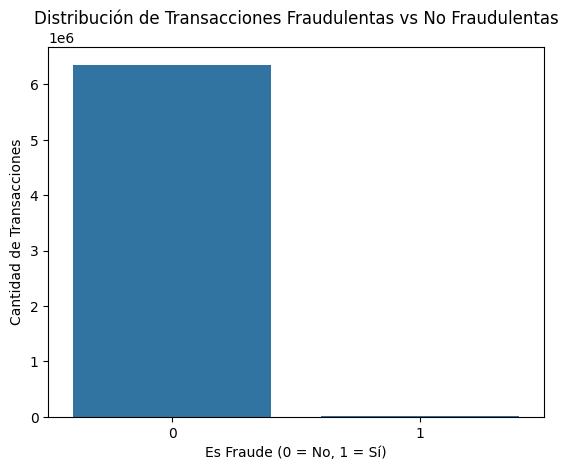

In [8]:
# Contar las clases en la variable objetivo ('isFraud')
fraud_counts = data['isFraud'].value_counts()
print("\nDistribución de clases:")
print(fraud_counts)  # Mostrar la distribución de clases (fraude vs no fraude)

# Visualizar la distribución de clases
sns.countplot(x='isFraud', data=data)  # Crear un gráfico de barras
plt.title('Distribución de Transacciones Fraudulentas vs No Fraudulentas')  # Título del gráfico
plt.xlabel('Es Fraude (0 = No, 1 = Sí)')  # Etiqueta del eje X
plt.ylabel('Cantidad de Transacciones')  # Etiqueta del eje Y
plt.show()  # Mostrar el gráfico

# *4.- Manejo del Desbalance de Clases*
Debido a que las transacciones fraudulentas son significativamente menos frecuentes que las no fraudulentas, utilizamos la técnica SMOTE (Synthetic Minority Over-sampling Technique) para balancear las clases y mejorar la capacidad del modelo para detectar fraudes.

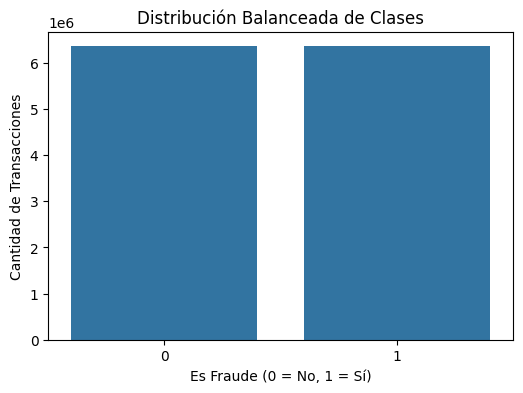


Desbalanceo corregido con SMOTE. Clases balanceadas.
isFraud
0    6354407
1    6354407
Name: count, dtype: int64


In [9]:
# Aplicar SMOTE para generar datos sintéticos y balancear las clases
smote = SMOTE(random_state=42)  # Crear una instancia de SMOTE con semilla
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)  # Aplicar SMOTE a los datos

# Visualizar la nueva distribución de clases balanceadas
plt.figure(figsize=(6, 4))  # Configurar tamaño del gráfico
sns.countplot(x=y_resampled)  # Crear un gráfico de barras para las clases balanceadas
plt.title('Distribución Balanceada de Clases')  # Título del gráfico
plt.xlabel('Es Fraude (0 = No, 1 = Sí)')  # Etiqueta del eje X
plt.ylabel('Cantidad de Transacciones')  # Etiqueta del eje Y
plt.show()  # Mostrar el gráfico

# Mostrar conteo de clases después de balancear
print("\nDesbalanceo corregido con SMOTE. Clases balanceadas.")
print(pd.Series(y_resampled).value_counts())  # Imprimir la nueva distribución de clases

# *5.- Evaluación con Modelos Clásicos de Machine Learning*
Entrenamos y evaluamos modelos clásicos de machine learning.

In [10]:
# Definir los modelos clásicos para evaluar
models = {
    'Regresión Logística': LogisticRegression(),  # Regresión Logística
    'Árbol de Decisión': DecisionTreeClassifier(),  # Árbol de Decisión
    'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=0)  # CatBoost
}

# Dividir los datos balanceados en conjuntos de entrenamiento y prueba
X_train_classic, X_test_classic, y_train_classic, y_test_classic = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled  # Mantener proporciones balanceadas
)

# Evaluar cada modelo clásico
for name, model in models.items():
    print(f"\nEvaluando modelo: {name}")  # Imprimir el nombre del modelo
    model.fit(X_train_classic, y_train_classic)  # Entrenar el modelo con datos de entrenamiento
    y_pred = model.predict(X_test_classic)  # Predecir en el conjunto de prueba

    # Mostrar el reporte de clasificación
    print(classification_report(y_test_classic, y_pred))  # Métricas de precisión, recall y F1-score


Evaluando modelo: Regresión Logística
              precision    recall  f1-score   support

           0       0.89      0.96      0.93   1270882
           1       0.96      0.88      0.92   1270881

    accuracy                           0.92   2541763
   macro avg       0.93      0.92      0.92   2541763
weighted avg       0.93      0.92      0.92   2541763


Evaluando modelo: Árbol de Decisión
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763


Evaluando modelo: CatBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00 

# *6.- Preparación de Datos para PyTorch*
Convertimos los datos balanceados en tensores para entrenar modelos de PyTorch.



In [11]:
# Dividir los datos balanceados para PyTorch
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Convertir las matrices en tensores para PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Tensor para características de entrenamiento
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # Tensor para etiquetas de entrenamiento
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Tensor para características de prueba
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)  # Tensor para etiquetas de prueba

# Crear DataLoaders para manejar los datos en minibatches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)  # Dataset para entrenamiento
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)  # Dataset para prueba
batch_size = 64  # Tamaño de lote
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader de entrenamiento
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # DataLoader de prueba

# *7.- Entrenamiento del Modelo PyTorch*
## a.- Definir la arquitectura del modelo.

In [12]:
# Definir el modelo de detección de fraudes
class FraudDetectionModel(nn.Module):
    def __init__(self):
        super(FraudDetectionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),  # Capa de entrada con 64 neuronas
            nn.ReLU(),  # Activación ReLU
            nn.Dropout(0.2),  # Dropout para prevenir sobreajuste
            nn.Linear(64, 32),  # Capa oculta con 32 neuronas
            nn.ReLU(),  # Activación ReLU
            nn.Dropout(0.2),  # Dropout
            nn.Linear(32, 1),  # Capa de salida con una neurona
            nn.Sigmoid()  # Activación sigmoide para salida binaria
        )

    def forward(self, x):
        return self.model(x)  # Definir la propagación hacia adelante

# Crear una instancia del modelo
model = FraudDetectionModel()

# Definir la función de pérdida y el optimizador
criterion = nn.BCELoss()  # Pérdida de entropía cruzada binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam

## b.- Entrenamiento de Modelo, seteo de epocas y visualizacion de la perdida de entrenamiento.

Época [1/10], Pérdida de Entrenamiento: 0.0386
Época [2/10], Pérdida de Entrenamiento: 0.0304
Época [3/10], Pérdida de Entrenamiento: 0.0284
Época [4/10], Pérdida de Entrenamiento: 0.0272
Época [5/10], Pérdida de Entrenamiento: 0.0269
Época [6/10], Pérdida de Entrenamiento: 0.0266
Época [7/10], Pérdida de Entrenamiento: 0.0252
Época [8/10], Pérdida de Entrenamiento: 0.0248
Época [9/10], Pérdida de Entrenamiento: 0.0246
Época [10/10], Pérdida de Entrenamiento: 0.0256


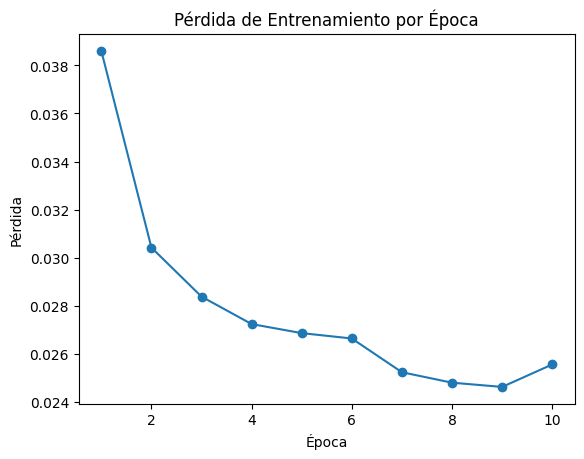

In [13]:
# Entrenar el modelo
num_epochs = 10  # Número de épocas
train_losses = []  # Lista para guardar las pérdidas por época
for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0  # Inicializar la pérdida acumulada
    for features, labels in train_loader:  # Iterar sobre los lotes de datos
        outputs = model(features)  # Propagación hacia adelante
        loss = criterion(outputs.view(-1), labels)  # Calcular pérdida
        optimizer.zero_grad()  # Limpiar gradientes
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos
        running_loss += loss.item()  # Acumular pérdida
    epoch_loss = running_loss / len(train_loader)  # Promediar la pérdida
    train_losses.append(epoch_loss)  # Guardar la pérdida de la época
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida de Entrenamiento: {epoch_loss:.4f}")

# Visualizar la pérdida de entrenamiento
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')  # Crear gráfica de la pérdida
plt.title('Pérdida de Entrenamiento por Época')  # Título
plt.xlabel('Época')  # Etiqueta del eje X
plt.ylabel('Pérdida')  # Etiqueta del eje Y
plt.show()  # Mostrar gráfico

# *8. Evaluación del Modelo PyTorch*
Evaluamos el modelo entrenado y mostramos las métricas de rendimiento.


Reporte de clasificación del modelo PyTorch:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1270882
         1.0       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763



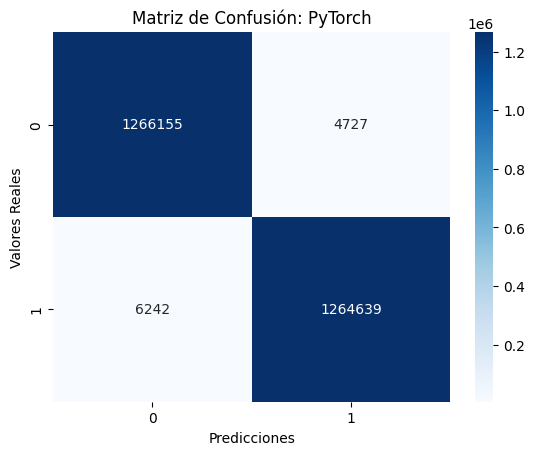

In [14]:
# Cambiar el modelo al modo de evaluación (desactiva dropout y batch normalization)
model.eval()

# Inicializar listas para almacenar las predicciones y etiquetas reales
all_preds = []  # Lista para las predicciones del modelo
all_labels = []  # Lista para las etiquetas reales

# Desactivar el cálculo de gradientes (reduce el uso de memoria y acelera el proceso)
with torch.no_grad():
    # Iterar sobre el DataLoader del conjunto de prueba
    for features, labels in test_loader:
        # Realizar la predicción
        outputs = model(features)  # Salidas del modelo
        # Convertir las probabilidades a etiquetas binarias (0 o 1) usando un umbral de 0.5
        preds = (outputs.view(-1) > 0.5).float()
        # Agregar las predicciones y etiquetas reales a las listas
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Generar el reporte de clasificación para evaluar el rendimiento del modelo
print("\nReporte de clasificación del modelo PyTorch:")
print(classification_report(all_labels, all_preds))

# Crear y visualizar la matriz de confusión
# Esto ayuda a identificar los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
cm = confusion_matrix(all_labels, all_preds)

# Visualización de la matriz de confusión como un mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión: PyTorch")
plt.xlabel("Predicciones")  # Etiqueta del eje X
plt.ylabel("Valores Reales")  # Etiqueta del eje Y
plt.show()
